# Input

Time series $Z$ mixed with noise
$$Y = Z + E,$$
where $E$ is a whitenoise
$$
cov(E_i, E_j) =
\begin{cases}
\sigma_e^2,& i = j \\
0,&          i \neq j
\end{cases} 
$$

$Z$ depends on $X_i, i = 1..6$ time series.

# Task
- Find and remove anomalies in $Y$
- Create regression model $\mu$: $Z = \mu\left( X \right)$
- Find prediction for three more values of $Z$ by
  - extrapolation of $Z$
  - model $\mu\left( X \right)$ and prediction of $X$
- Estimate prediction errors
- Choose the best prediction

# Tools
- [Exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)
- [Autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

In [2]:
from numpy import loadtxt, arange, log, delete, array
from scipy.stats import f
from pandas.stats.moments import ewma

In [3]:
dataset = loadtxt('data.csv', skiprows=1, delimiter=',')
t = arange(dataset.shape[0])
y = dataset[:, 0]
xs = dataset[:, 1:].transpose()

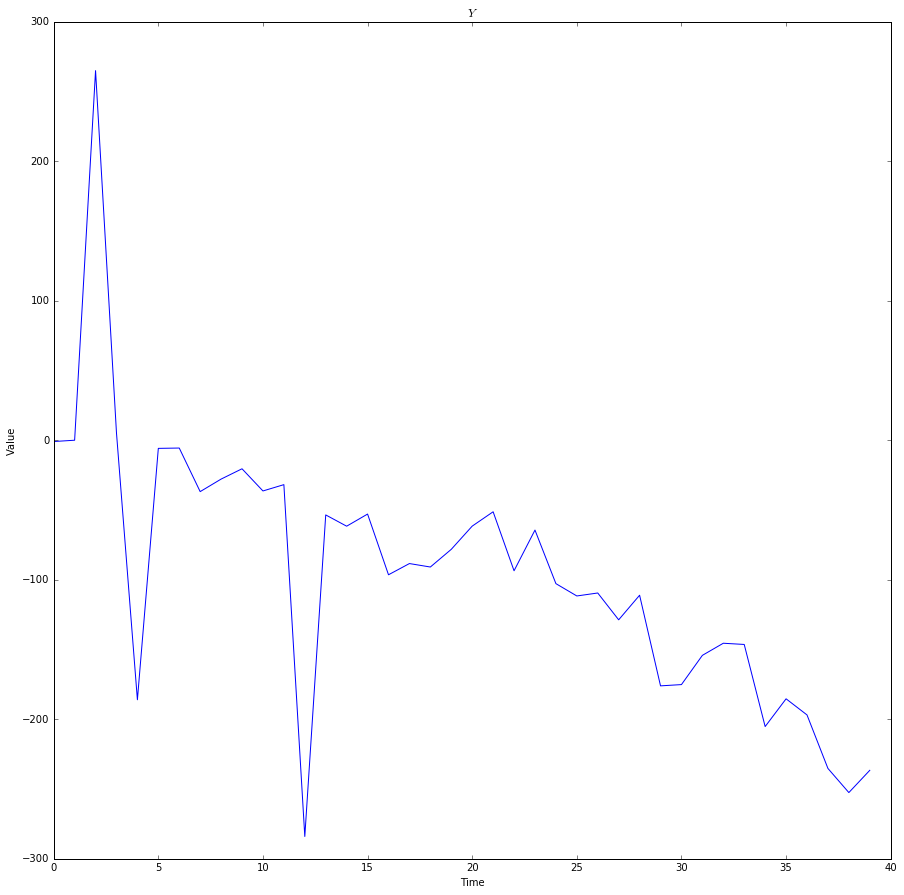

In [4]:
plt.plot(t, y)
plt.title('$Y$')
plt.ylabel('Value')
plt.xlabel('Time')
plt.show()

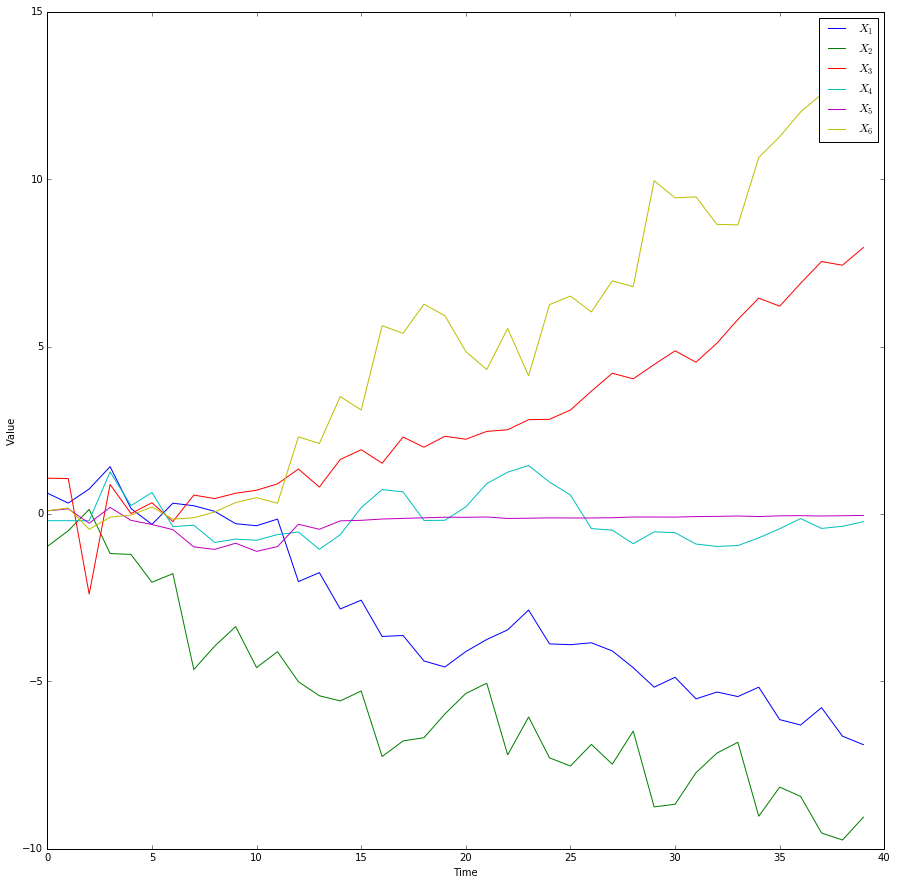

In [5]:
for i, x in enumerate(xs):
    plt.plot(t, x, label='$X_%d$'%(i+1))

plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.show()

# Smoothing

## Initial smoothing

Exponential moving average with window size $10$ will be used

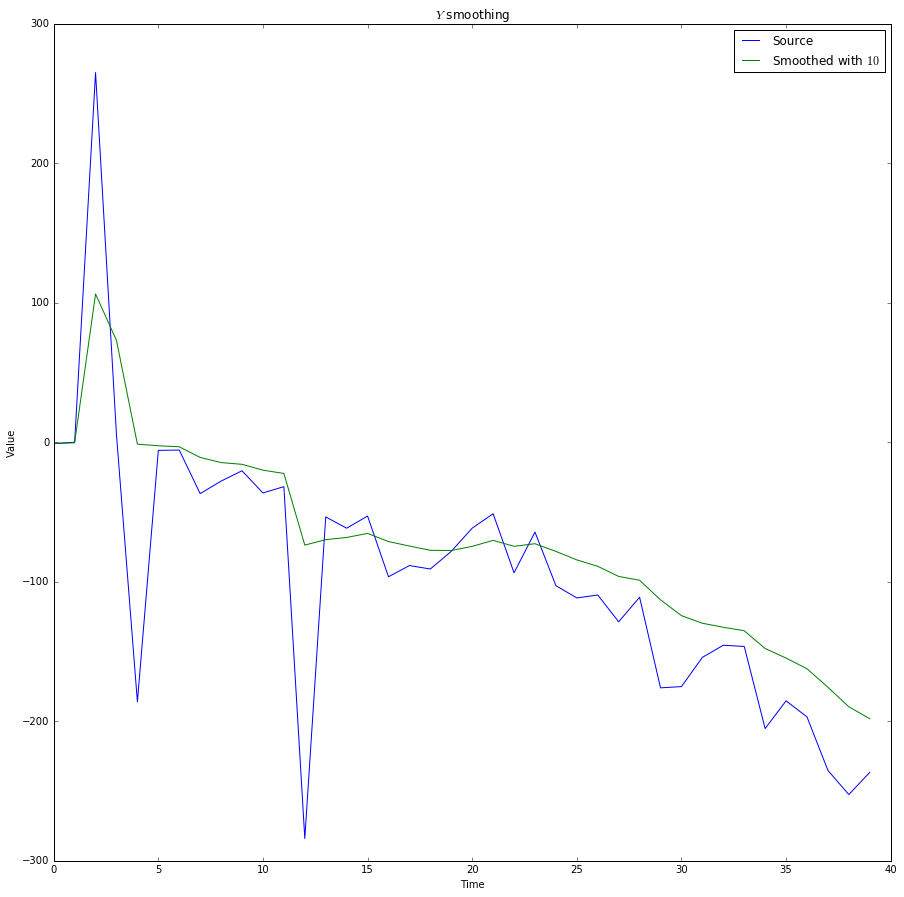

In [6]:
span = 10
smoothed_y = ewma(y, span=span)

plt.plot(t, y, label='Source')
plt.plot(t, smoothed_y, label='Smoothed with $%d$'%span)

plt.title('$Y$ smoothing')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

## Find anomalies

Anomaly points are the ones which affect smoothing.

We can find them as points which increase standard deviation of smoothing errors a lot.

Given an anomaly point $t$ we can build new time series $Y_{fixed}\left( t \right)$ without this point
and check whether this point is really anomaly
$$
V\left( t \right)
= \frac{Var\left( Y - Y^{smoothed} \right)}
       {Var\left( Y_{fixed}\left(t\right) - Y_{fixed}^{smoothed}\left(t\right) \right)}
> V_{critical}
$$

It's an [F-test](https://en.wikipedia.org/wiki/F-test) and we can do it in following way
$$
\max\limits_{t}{F_{F, T, T-1}\left( V\left( t \right) \right)} > F_{F, T, T-1}^{critical}
\Longrightarrow
t_{anomaly} = \max\limits_{t}{F_{F, T, T-1}\left( V\left( t \right) \right)}.
$$

In [7]:
def get_fixed_std(data_series, position, span):
    data_series = delete(data_series, position)
    return (data_series - ewma(data_series, span=span)).std()

In [8]:
def get_f_test_values(data_series, span):
    smoothed_series = ewma(y, span=span)
    anomalies_stds = [get_fixed_std(y, i, span) for i in t]
    anomalies = array([(data_series - smoothed_series).std() / std for std in anomalies_stds])**2
    return anomalies

In [12]:
def get_f_weights(anomalies):
    return [1 - f.cdf(anomaly, anomalies.size - 1, anomalies.size - 2) for anomaly in anomalies]

In [13]:
def display_variances_without_anomalies(data, anomaly_points=()):
    for anomaly_point in anomaly_points:
        data = delete(data, anomaly_point)
    anomalies = get_f_test_values(y, span)

    plt.plot(t, anomalies)
    plt.title('Variances ratios between series wihout anomaly points and original one')
    plt.xlabel('Anomaly point')
    plt.ylabel('Variance')
    plt.show()

    plt.plot(t, get_f_weights(anomalies))
    plt.title('F-test tail weights')
    plt.xlabel('Anomaly point')
    plt.ylabel('Tail weight')
    plt.show()

Let's take a look on variances of fixed time series, which don't contain specific points,
and plot which contains weight of Fisher distribution tails for each fixed time series

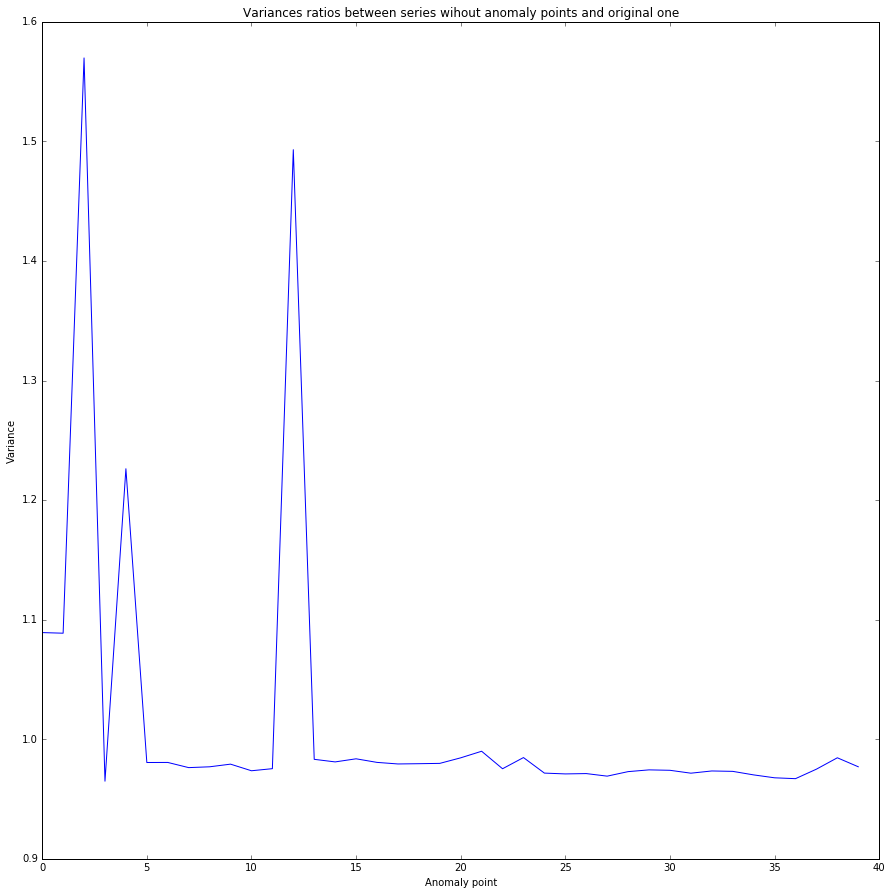

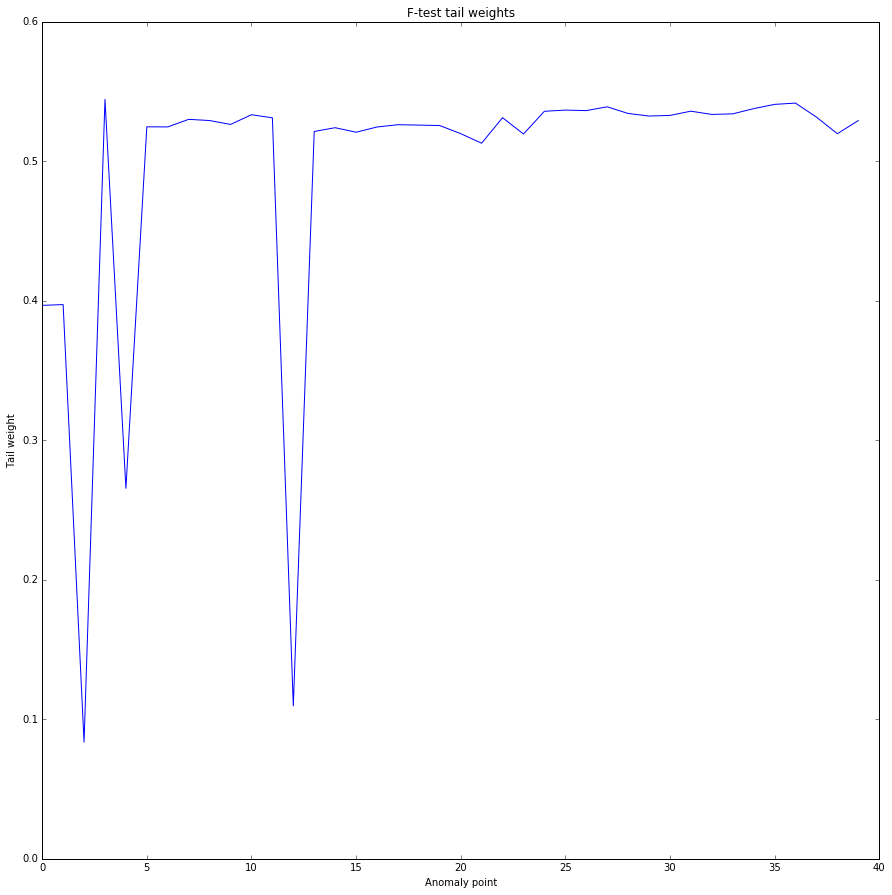

In [15]:
display_variances_without_anomalies(y)